# **Gesture Recognition**

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Project_data.zip','r') as zip:
    zip.extractall()

In [ ]:
pip install imread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import imageio
import imread
from skimage.transform import resize, rescale
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [ ]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

2.15.0


In [ ]:
import cv2
import matplotlib.pyplot as plt

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/val.csv').readlines())
batch_size = 8  #number of softmax classes

**Generator**

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [ ]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

In [ ]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))

    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Let's test the function resize_crop_image by writing a test function

In [ ]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))

        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')

        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')

    plt.show()

Calling the test function

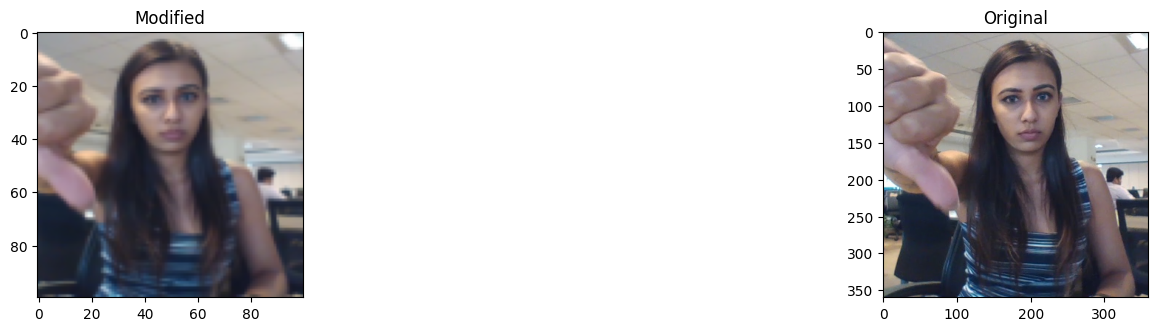

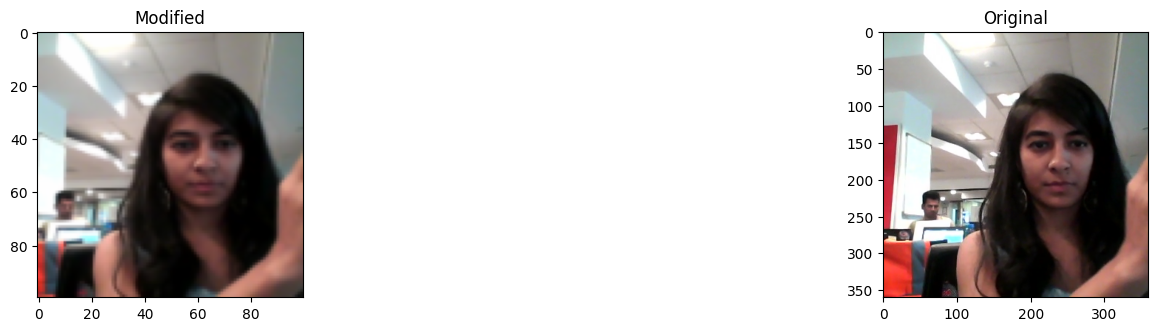

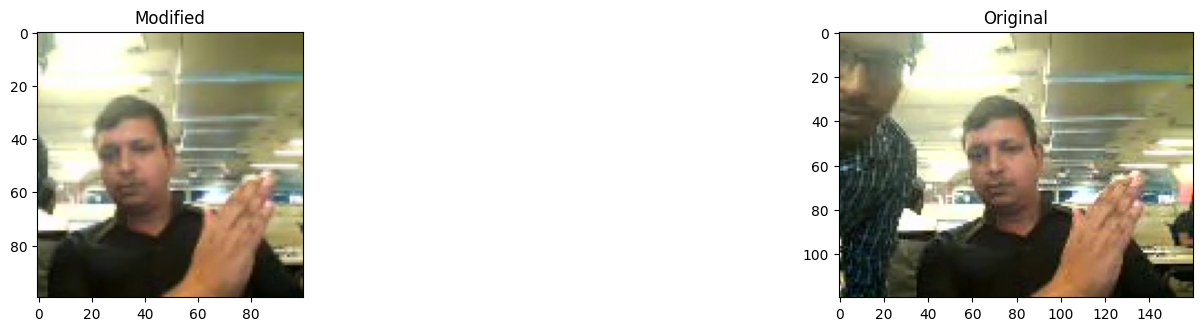

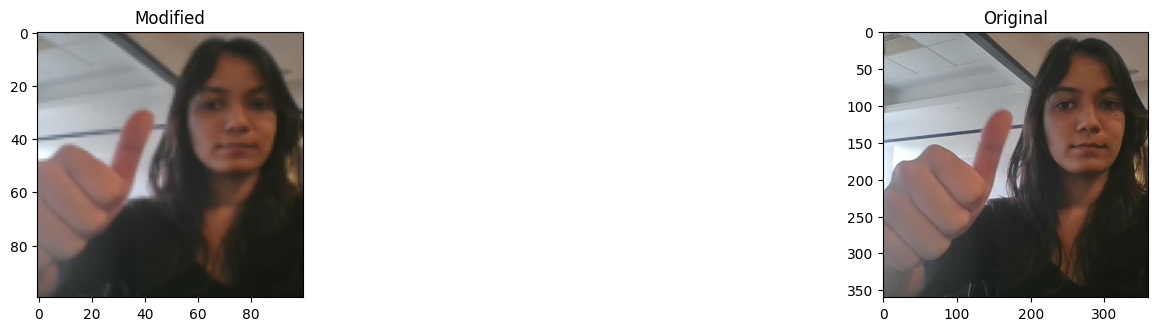

In [ ]:
paths = ["/content/drive/MyDrive/Project_data/Project_data/train/WIN_20180907_15_53_00_Pro_Thumbs Down_new/WIN_20180907_15_53_00_Pro_00001.png",
        "/content/drive/MyDrive/Project_data/Project_data/train/WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00013.png",
        "/content/drive/MyDrive/Project_data/Project_data/train/WIN_20180925_17_22_32_Pro_Right_Swipe_new/WIN_20180925_17_22_32_Pro_00009.png",
        "/content/drive/MyDrive/Project_data/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00011.png"]

show_resize_crop_image(paths)

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)

            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


**Model**

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

**Experiment 1**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [ ]:
opt = optimizers.Adam() #write your optimizer
model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization (Batch  (None, 15, 100, 100, 8)   32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 50, 50, 8)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 16)     3472      
                                                                 
 batch_normalization_1 (Bat  (None, 7, 50, 50, 16)     6

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit method to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 2.1190 - categorical_accuracy: 0.1961 Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.72493, saving model to model_init_2024-04-0405_08_36.301804/model-00001-2.11899-0.19608-1.72493-0.23000.h5
83/83 [==============================] - 3602s 44s/step - loss: 2.1190 - categorical_accuracy: 0.1961 - val_loss: 1.7249 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5734 - categorical_accuracy: 0.2324
Epoch 2: val_loss improved from 1.72493 to 1.39364, saving model to model_init_2024-04-0405_08_36.301804/model-00002-1.57339-0.23236-1.39364-0.38462.h5
83/83 [==============================] - 320s 4s/step - loss: 1.5734 - categorical_accuracy: 0.2324 - val_loss: 1.3936 - val_categorical_accuracy:

**Training Accuracy:** 0.35%

**Validation Accuracy:** 0.5%

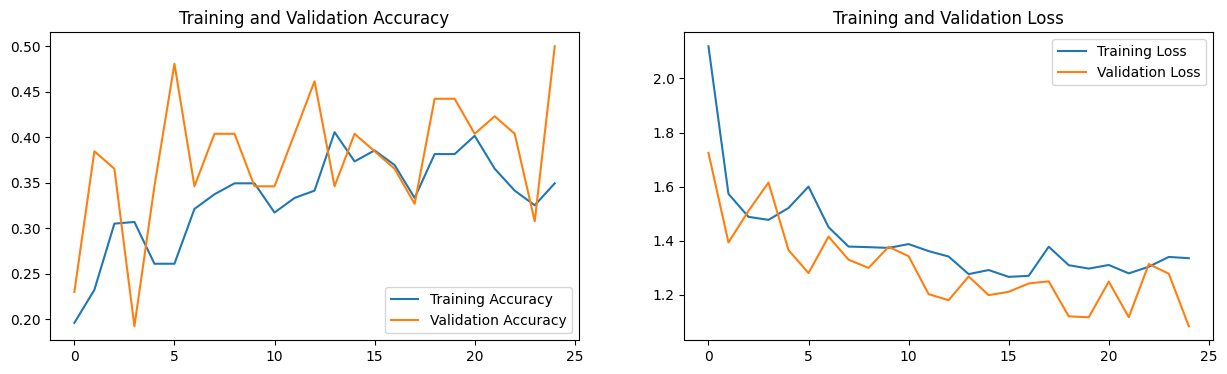

In [ ]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

From the graph we can see that the model is performing better on the validation data than on the training data. This indicates that the model is too simple and has lesser that required training parameters

**Experiment 2**

Reducing the size of the image from 100 to 50

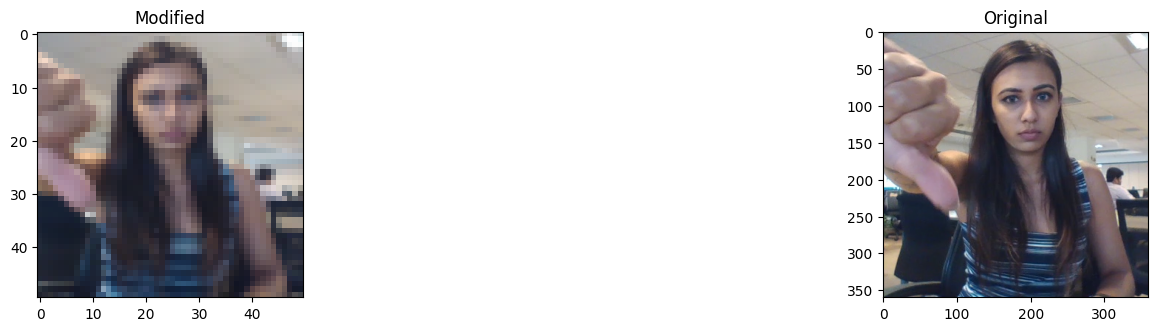

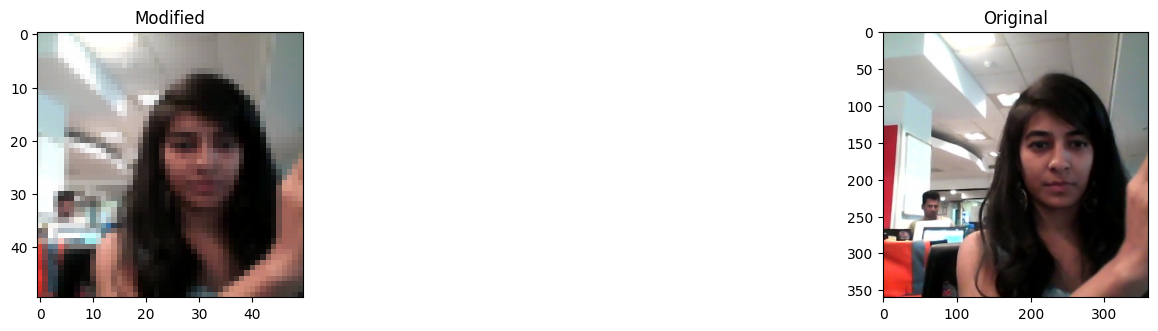

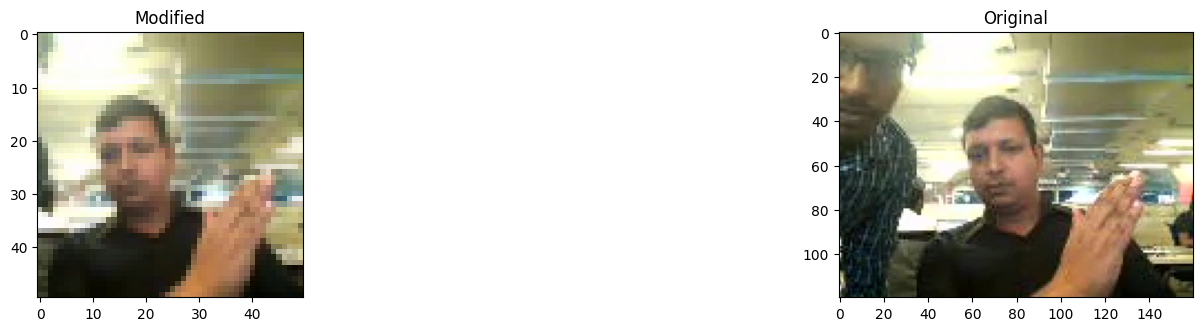

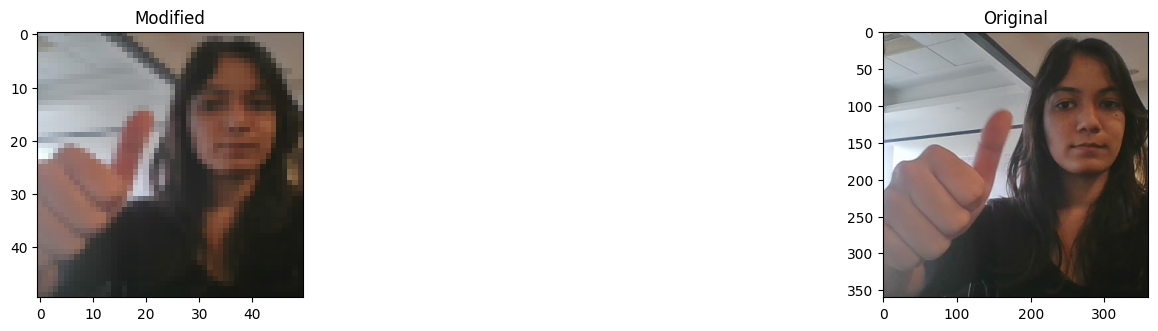

In [ ]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [ ]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [ ]:
opt = optimizers.Adam() #write your optimizer
model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_3 (Bat  (None, 15, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 7, 25, 25, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 25, 25, 16)    

Creating the generators

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.8141 - categorical_accuracy: 0.2066Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.61102, saving model to model_exp2_2024-04-0405_08_36.301804/model-00001-1.81409-0.20664-1.61102-0.17000.h5
83/83 [==============================] - 211s 3s/step - loss: 1.8141 - categorical_accuracy: 0.2066 - val_loss: 1.6110 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6088 - categorical_accuracy: 0.2134
Epoch 2: val_loss improved from 1.61102 to 1.60972, saving model to model_exp2_2024-04-0405_08_36.301804/model-00002-1.60876-0.21343-1.60972-0.15385.h5
83/83 [==============================] - 167s 2s/step - loss: 1.6088 - categorical_accuracy: 0.2134 - val_loss: 1.6097 - val_categorical_accuracy: 0.

Evaluate the performance of this model

**Training Accuracy:** 0.34%

**Validation Accuracy:** 0.48%

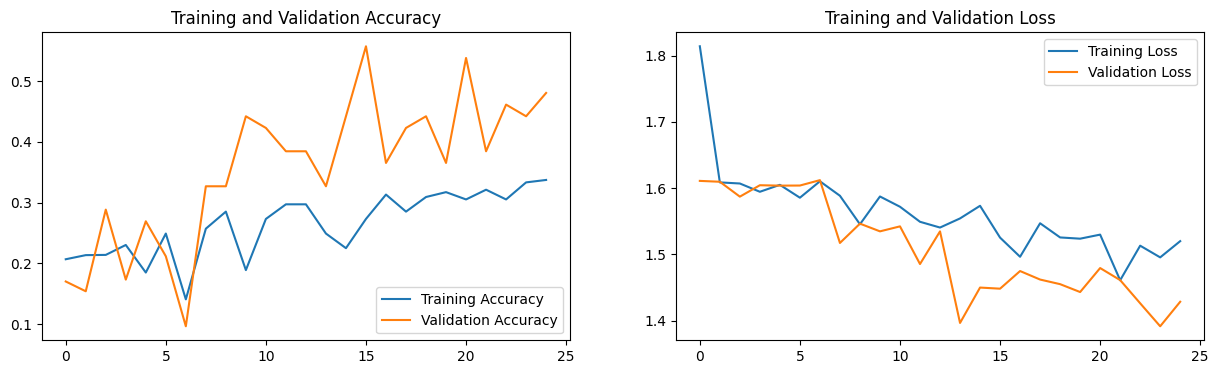

In [ ]:
plot_history(history)

Conclusion: Scaling to smaller images not much improvement.



**Experiment 3**

Reducing the size of the image from 50 to 25

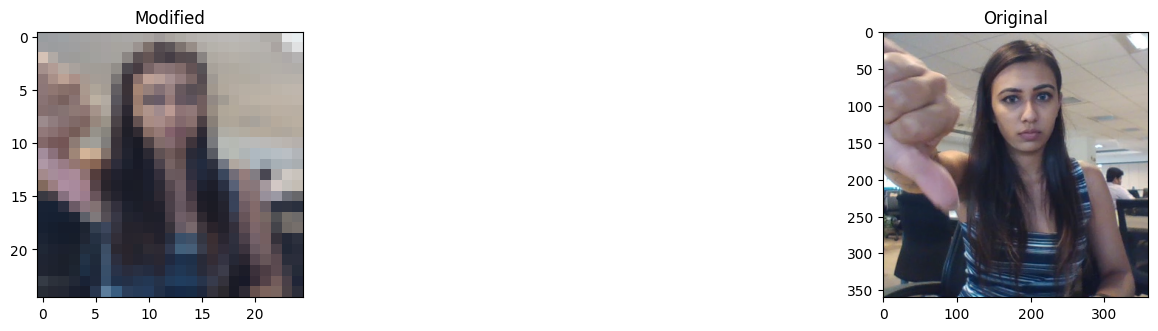

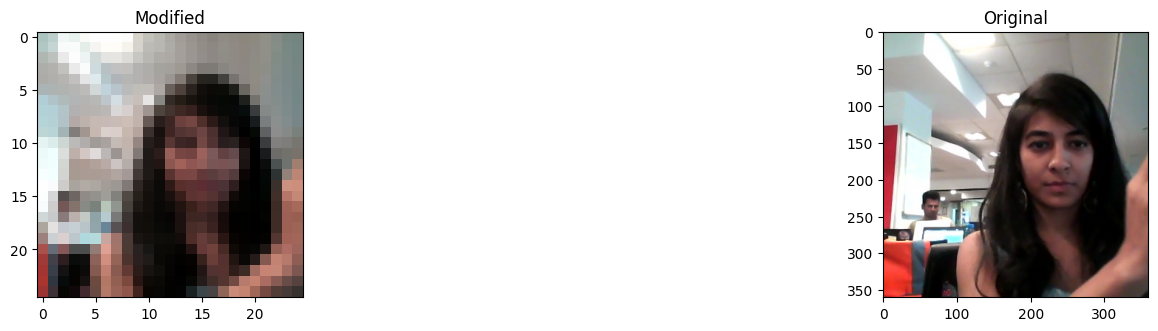

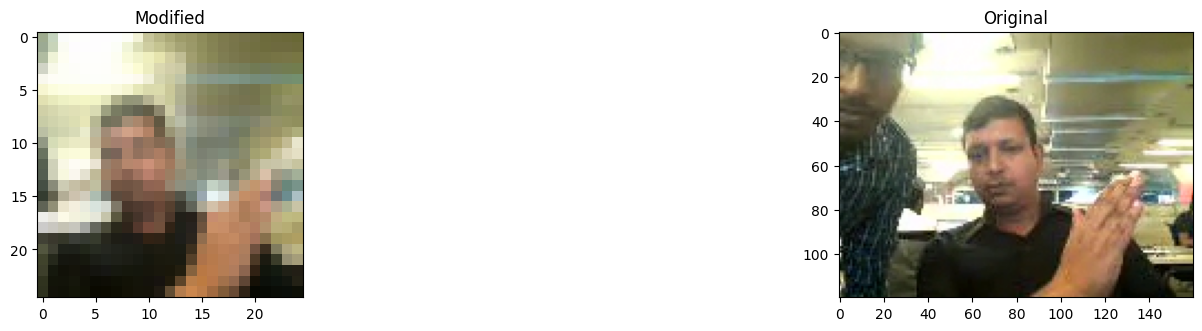

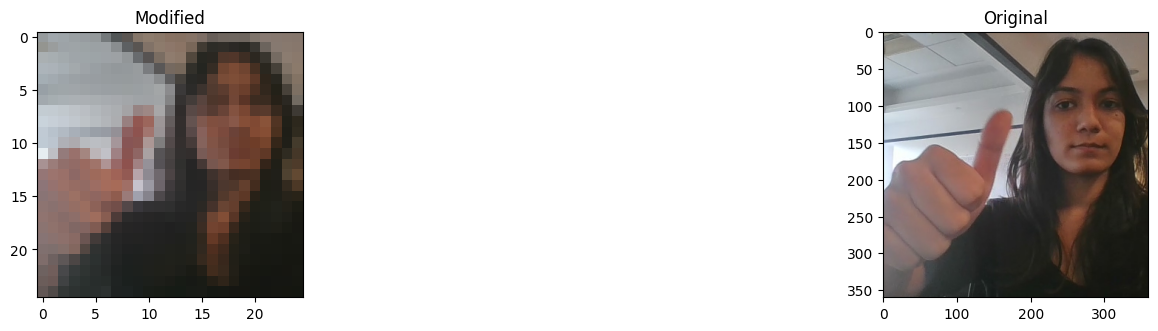

In [ ]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [ ]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [ ]:
opt = optimizers.Adam() #write your optimizer
model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 25, 25, 8)     656       
                                                                 
 batch_normalization_6 (Bat  (None, 15, 25, 25, 8)     32        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 15, 25, 25, 8)     0         
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 7, 12, 12, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 12, 12, 16)     3472      
                                                                 
 batch_normalization_7 (Bat  (None, 7, 12, 12, 16)    

Creating the generators

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7697 - categorical_accuracy: 0.2293Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.85818, saving model to model_exp3_2024-04-0405_08_36.301804/model-00001-1.76970-0.22926-1.85818-0.21000.h5
83/83 [==============================] - 181s 2s/step - loss: 1.7697 - categorical_accuracy: 0.2293 - val_loss: 1.8582 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5312 - categorical_accuracy: 0.2978
Epoch 2: val_loss improved from 1.85818 to 1.49500, saving model to model_exp3_2024-04-0405_08_36.301804/model-00002-1.53118-0.29776-1.49500-0.32692.h5
83/83 [==============================] - 145s 2s/step - loss: 1.5312 - categorical_accuracy: 0.2978 - val_loss: 1.4950 - val_categorical_accuracy: 0.

Evaluate the Performance

**Training Accuracy:** 0.63%

**Validation Accuracy:** 0.63%

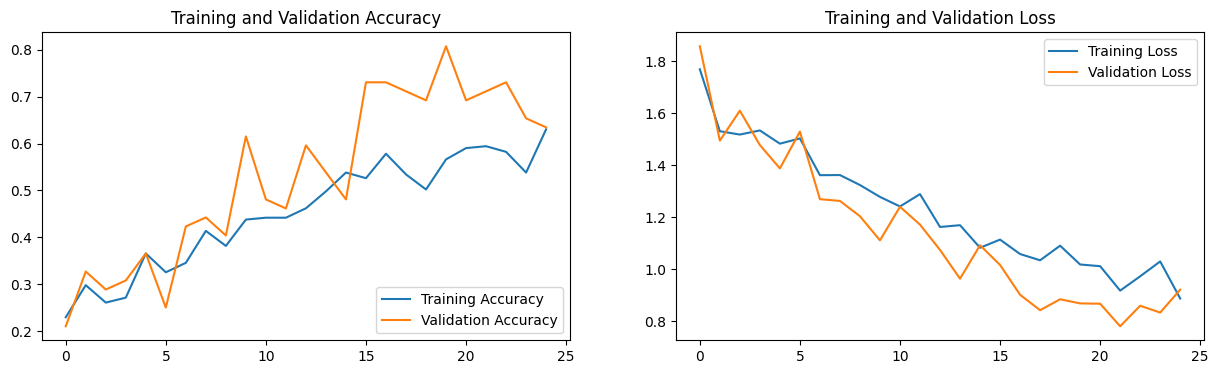

In [ ]:
plot_history(history)

Conclusion: Scaling from 50 to 25 increased the training and validation accuracy

**Experiment 4**

Decreasing the batch size from 8 to 4

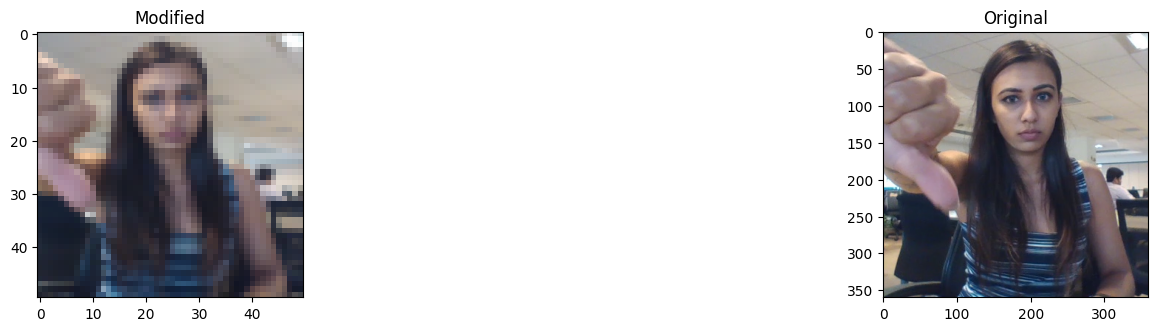

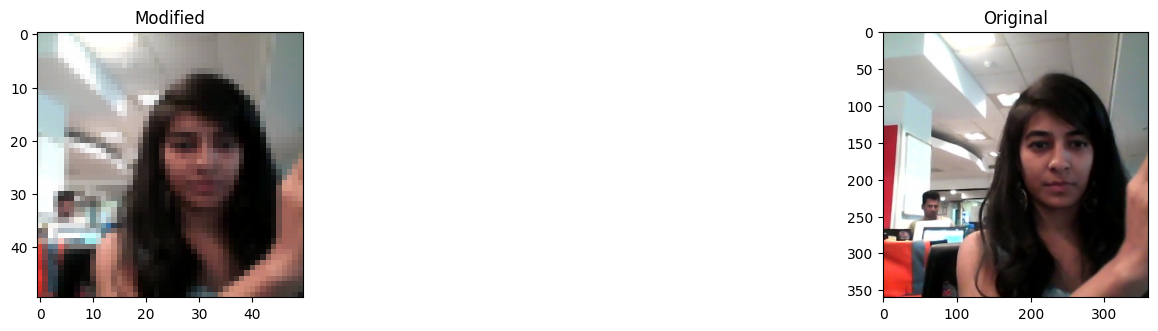

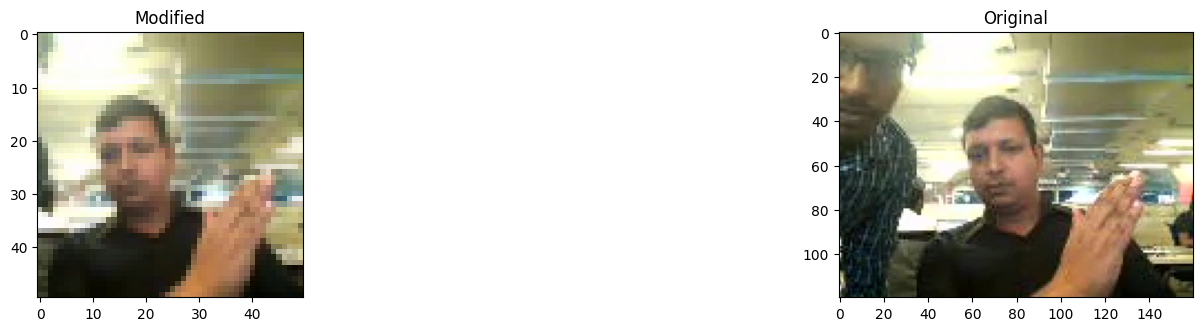

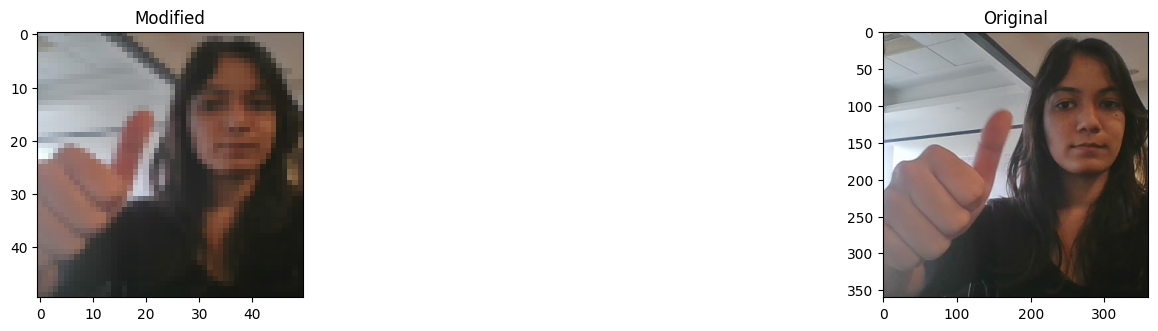

In [ ]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

show_resize_crop_image(paths)

In [ ]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [ ]:
opt = optimizers.Adam() #write your optimizer
model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_9 (Bat  (None, 15, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 7, 25, 25, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_10 (Ba  (None, 7, 25, 25, 16)    

Creating the generators

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the model parameters

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7983 - categorical_accuracy: 0.2308Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.55336, saving model to model_exp4_2024-04-0405_08_36.301804/model-00001-1.79825-0.23077-1.55336-0.24000.h5
166/166 [==============================] - 213s 1s/step - loss: 1.7983 - categorical_accuracy: 0.2308 - val_loss: 1.5534 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.5957 - categorical_accuracy: 0.2450
Epoch 2: val_loss did not improve from 1.55336
166/166 [==============================] - 150s 907ms/step - loss: 1.5957 - categorical_accuracy: 0.2450 - val_loss: 1.5817 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.5893

**Training Accuracy:** 0.43%

**Validation Accuracy:** 0.68%

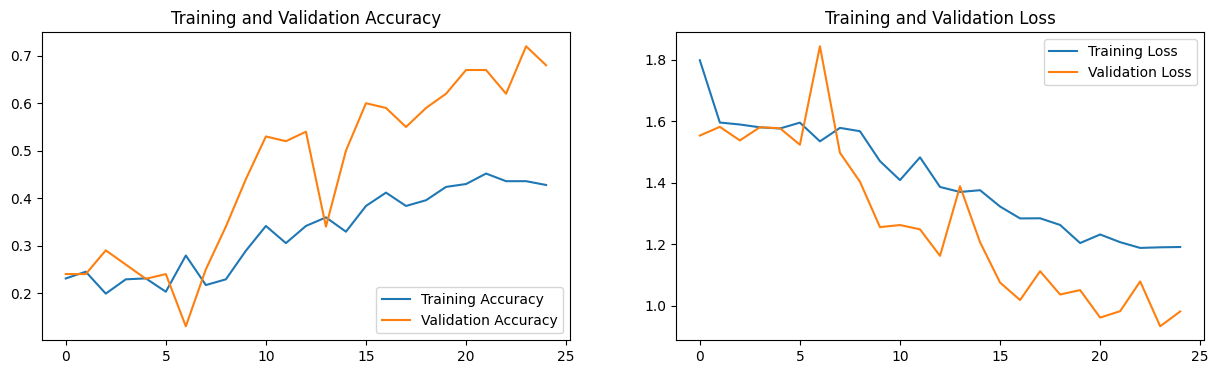

In [ ]:
plot_history(history)

Conclusion: Reducing the batch size has reduced the training accuracy, and improved the validation accuracy. Indirectly, it reduced the overfitting.

**Experiment 5**

Changing the optimizer from Adam to SGD

In [ ]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [ ]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_21 (Ba  (None, 15, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_21 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_21 (MaxPooli  (None, 7, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_22 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_22 (Ba  (None, 7, 25, 25, 16)    

Creating generators

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [81]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model and save the parameters

In [57]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7572 - categorical_accuracy: 0.2112Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.61440, saving model to model_exp4_2024-04-0405_08_36.301804/model-00001-1.75724-0.21116-1.61440-0.22000.h5
166/166 [==============================] - 218s 1s/step - loss: 1.7572 - categorical_accuracy: 0.2112 - val_loss: 1.6144 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6230 - categorical_accuracy: 0.1787
Epoch 2: val_loss improved from 1.61440 to 1.60381, saving model to model_exp4_2024-04-0405_08_36.301804/model-00002-1.62303-0.17871-1.60381-0.20000.h5
166/166 [==============================] - 172s 1s/step - loss: 1.6230 - categorical_accuracy: 0.1787 - val_loss: 1.6038 - val_categorical_accu

**Training Accuracy:** 0.53%

**Validation Accuracy:** 0.69%

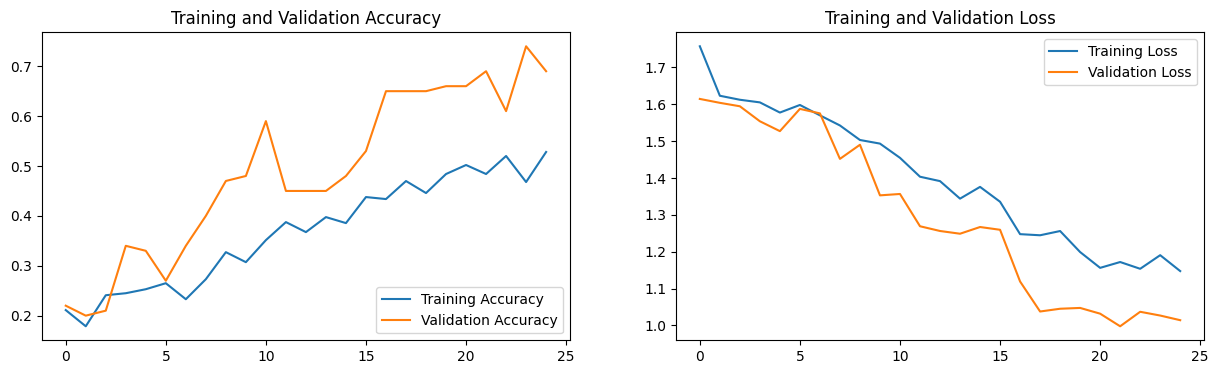

In [58]:
plot_history(history)

Conclusion: Validation accuracy increased by 1%, but training accuracy is improved, which meaning model is prone to overfitting compared to Adam optimizer.

**Experiment 6**

Reducing the number of frames from 15 to 10

In [59]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [60]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_24 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_25 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_25 (Ba  (None, 5, 25, 25, 16)    

Create Generator

In [61]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [62]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [63]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7855 - categorical_accuracy: 0.1840Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60673, saving model to model_exp6_2024-04-0405_08_36.301804/model-00001-1.78551-0.18401-1.60673-0.24000.h5
166/166 [==============================] - 1147s 7s/step - loss: 1.7855 - categorical_accuracy: 0.1840 - val_loss: 1.6067 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6105 - categorical_accuracy: 0.1847
Epoch 2: val_loss did not improve from 1.60673
166/166 [==============================] - 108s 654ms/step - loss: 1.6105 - categorical_accuracy: 0.1847 - val_loss: 1.6077 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
166/166 [==============================] - ETA: 0s - loss: 1.609

**Training Accuracy:** 0.25%

**Validation Accuracy:** 0.41%

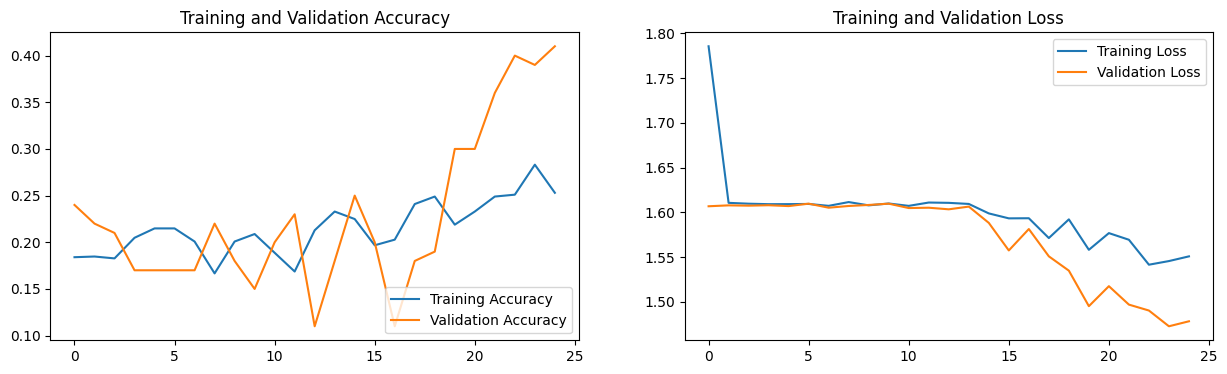

In [65]:
plot_history(history)

Conclusion: The training and validation accuracy has decreased after reducing the number of frames from 15 to 10



**Experiment 7**

Reducing the dropout rate from 0.5 to 0.25

In [66]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [67]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_27 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_27 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_28 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_28 (Ba  (None, 5, 25, 25, 16)    

In [68]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [69]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [70]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7258 - categorical_accuracy: 0.1870Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60411, saving model to model_exp7_2024-04-0405_08_36.301804/model-00001-1.72581-0.18703-1.60411-0.21000.h5
166/166 [==============================] - 138s 823ms/step - loss: 1.7258 - categorical_accuracy: 0.1870 - val_loss: 1.6041 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6022 - categorical_accuracy: 0.2048
Epoch 2: val_loss improved from 1.60411 to 1.59865, saving model to model_exp7_2024-04-0405_08_36.301804/model-00002-1.60221-0.20482-1.59865-0.22000.h5
166/166 [==============================] - 106s 641ms/step - loss: 1.6022 - categorical_accuracy: 0.2048 - val_loss: 1.5987 - val_categorica

**Training Accuracy:** 0.62%

**Validation Accuracy:** 0.7%

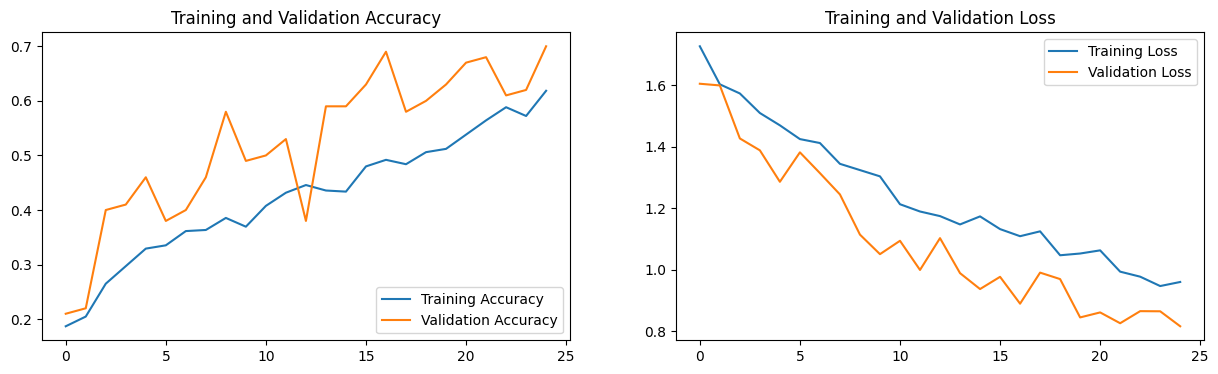

In [72]:
plot_history(history)

Conclusion: A drop out rate of 0.25 gives up a better training and validation accuracy

**Experiment 8**
Increasing the number of epochs from 25 to 35

In [73]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [74]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_30 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_30 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_30 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_31 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_31 (Ba  (None, 5, 25, 25, 16)   

In [75]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [76]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [77]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [78]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.5623 - categorical_accuracy: 0.3288Source path =  /content/drive/MyDrive/Project_data/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.26443, saving model to model_exp8_2024-04-0405_08_36.301804/model-00001-1.56232-0.32881-1.26443-0.42000.h5
166/166 [==============================] - 144s 857ms/step - loss: 1.5623 - categorical_accuracy: 0.3288 - val_loss: 1.2644 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.3431 - categorical_accuracy: 0.4096
Epoch 2: val_loss did not improve from 1.26443
166/166 [==============================] - 110s 664ms/step - loss: 1.3431 - categorical_accuracy: 0.4096 - val_loss: 1.6311 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 3/35
166/166 [==============================] - ETA: 0s - loss: 1.2

**Training Accuracy:** 0.9%

**Validation Accuracy:** 0.81%

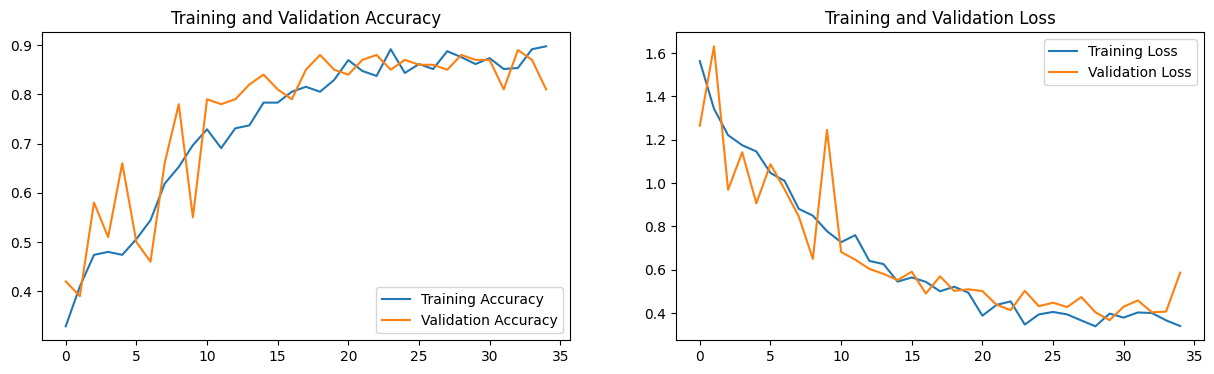

In [79]:
plot_history(history)

Conclusion: After 35 epochs the training and validation accuracy changes to 90% and 81% respectively